## Learning Black-Scholes Equation for Vanilla Options

In [11]:
import numpy as np
import torch
import csv
import matplotlib.pyplot as plt

In [2]:
dataset = []
with open('../data/black_scholes.csv', newline='\n') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  for row in reader:
    dataset.append(row)

train_set, test_set = np.array(dataset[:240000], dtype=float), np.array(dataset[240000:], dtype=float)
train_features, train_labels = torch.from_numpy(train_set[:, 0:5]), torch.from_numpy(train_set[:, 5]).reshape(-1, 1)
test_features, test_labels = torch.from_numpy(test_set[:, 0:5]), torch.from_numpy(test_set[:, 5]).reshape(-1, 1)

In [3]:
batch_size = 128
train_iter = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_features, train_labels),
                                         batch_size,
                                         shuffle=True)
test_iter = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_features, test_labels),
                                        batch_size,
                                        shuffle=False)


In [4]:
num_inputs = 5
num_hidden = 100
num_outputs = 1
model = torch.nn.Sequential(torch.nn.Linear(num_inputs, num_hidden),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(num_hidden, num_hidden),
                            torch.nn.ELU(),
                            torch.nn.Linear(num_hidden, num_hidden),
                            torch.nn.ReLU(),
                            torch.nn.Linear(num_hidden, num_hidden),
                            torch.nn.ELU(),
                            torch.nn.Linear(num_hidden, num_outputs))

In [5]:
loss = torch.nn.MSELoss()

In [6]:
learning_rate = 0.004
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [7]:
num_epochs = 10
for epoch in range(num_epochs):
  for X, y in train_iter:
    l = loss(model(X.float()), y.float())

    optimizer.zero_grad()
    l.backward()
    optimizer.step()

  l = loss(model(train_features.float()), train_labels.float())
  print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.009690
epoch 2, loss 0.005575
epoch 3, loss 0.005301
epoch 4, loss 0.006362
epoch 5, loss 0.005501
epoch 6, loss 0.004765
epoch 7, loss 0.004720
epoch 8, loss 0.004711
epoch 9, loss 0.006888
epoch 10, loss 0.004524


In [8]:
with torch.no_grad():
  print(model(train_features[:5].float()))
  print(train_labels[:5].float())

tensor([[-2.1074e-02],
        [ 1.0272e-02],
        [ 2.2774e-01],
        [ 3.4066e+01],
        [-8.1836e-04]])
tensor([[0.0000e+00],
        [1.0551e-02],
        [2.4765e-01],
        [3.4387e+01],
        [5.1302e-14]])


In [9]:
with torch.no_grad():
  l = loss(model(test_features.float()), test_labels.float())
  print(f'loss {l:f}')

loss 0.004646


In [10]:
torch.save(model.state_dict(), '../save/black_scholes.ckpt')

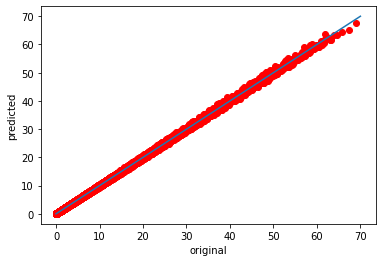

In [12]:
with torch.no_grad():
  predicted = model(train_features.float()).numpy().reshape(-1)
  original = train_labels.numpy().reshape(-1)

  plt.plot(original, predicted, 'ro')
  plt.xlabel("original")
  plt.ylabel("predicted")
  plt.plot([0, 70], [0, 70])
  plt.show()

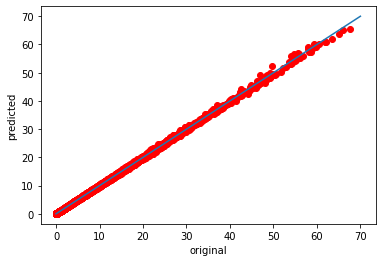

In [14]:
with torch.no_grad():
  predicted = model(test_features.float()).numpy().reshape(-1)
  original = test_labels.numpy().reshape(-1)

  plt.plot(original, predicted, 'ro')
  plt.xlabel("original")
  plt.ylabel("predicted")
  plt.plot([0, 70], [0, 70])
  plt.show()

In [22]:
from synthetic_black_scholes_data import value_call_option
import random

strike = random.uniform(7, 650)
spot = random.uniform(10, 500)
maturity = random.randint(1, 1095) / 365.
dividend = random.uniform(.0,  .03)
discount = random.uniform(.01, .03)
volatility = random.uniform(.05, .9)

price = value_call_option(strike, spot, maturity, dividend, discount, volatility) / strike
predicted = model(torch.tensor([spot / strike, maturity, dividend, discount, volatility])).detach()
print(price)
print(predicted)

0.5008855378998333
tensor([0.4817])
